# Labo III
# Multinacional - Prediccion de Ventas

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

## Cargo datasets y limpieza

In [2]:
# Load the data aggregated_montly_sales.csv using pandas
data = pd.read_csv('datasets/aggregated_montly_sales.csv', parse_dates=['periodo'])

In [3]:
data.head()

,periodo,product_id,tn,cat1,cat2,cat3,brand,sku_size,descripcion,ipc,exchange_rate
0,2017-01-01,20001,934.77220,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1.6,16.96
1,2017-01-01,20002,550.15704,HC,ROPA LAVADO,Liquido,LIMPIEX,3000.0,Maquina 1er lavado,1.6,16.96
2,2017-01-01,20003,1063.45840,FOODS,ADEREZOS,Mayonesa,NATURA,475.0,Regular sin TACC,1.6,16.96
3,2017-01-01,20004,555.91614,FOODS,ADEREZOS,Mayonesa,NATURA,240.0,Regular sin TACC,1.6,16.96
4,2017-01-01,20005,494.27010,FOODS,ADEREZOS,Mayonesa,NATURA,120.0,Regular sin TACC,1.6,16.96


In [4]:
print(data.shape)
print(data.dtypes)

(31243, 11)
periodo          datetime64[ns]
product_id                int64
tn                      float64
cat1                     object
cat2                     object
cat3                     object
brand                    object
sku_size                float64
descripcion              object
ipc                     float64
exchange_rate           float64
dtype: object


In [5]:
data = data.sort_values(["product_id", "periodo"]).reset_index(drop=True)

## Fill with 0 when there were no sales

In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# Build a COMPLETE product-month grid (0 = “no sales that month”)
# ─────────────────────────────────────────────────────────────────────────────
static_cols  = ["cat1", "cat2", "cat3", "brand", "sku_size"]
dynamic_cols = ["tn", "ipc", "exchange_rate"]           # metrics that vary monthly

# 1) One clean row per SKU with its static descriptors
sku_static = (
    data
      .sort_values(static_cols)         # deterministic pick
      .groupby("product_id", as_index=False)[static_cols]
      .first()
)

# 2) All calendar months present in the dataset
all_months = pd.period_range(
                data["periodo"].min(),
                data["periodo"].max(),
                freq="M"
             ).to_timestamp()            # → Timestamp('YYYY-MM-01')

# 3) Cartesian product: every (product_id, month) combination
full_idx = pd.MultiIndex.from_product(
             [sku_static["product_id"], all_months],
             names=["product_id", "periodo"]
           )

# 4) Keep ONLY the dynamic columns while re-indexing to avoid duplicate statics
data_dyn = data[["product_id", "periodo", *dynamic_cols]]

monthly_full = (
    data_dyn
      .set_index(["product_id", "periodo"])
      .reindex(full_idx, fill_value=0)     # zero = “no activity” month
      .reset_index()
)

# 5) Bring static attributes back exactly once
monthly_full = (
    monthly_full
      .merge(sku_static, on="product_id", how="left", validate="many_to_one")
      .sort_values(["product_id", "periodo"])
      .reset_index(drop=True)
)


In [7]:
print(monthly_full.shape)
print(monthly_full.head().to_string())

(44388, 10)
   product_id    periodo         tn  ipc  exchange_rate cat1         cat2     cat3  brand  sku_size
0       20001 2017-01-01   934.7722  1.6          16.96   HC  ROPA LAVADO  Liquido  ARIEL    3000.0
1       20001 2017-02-01   798.0162  2.1          16.59   HC  ROPA LAVADO  Liquido  ARIEL    3000.0
2       20001 2017-03-01  1303.3577  2.4          16.21   HC  ROPA LAVADO  Liquido  ARIEL    3000.0
3       20001 2017-04-01  1069.9613  2.7          15.96   HC  ROPA LAVADO  Liquido  ARIEL    3000.0
4       20001 2017-05-01  1502.2013  1.4          15.95   HC  ROPA LAVADO  Liquido  ARIEL    3000.0


In [8]:
# Count different periodo and product_id
print("Unique periods:", monthly_full["periodo"].nunique())
print("Unique products:", monthly_full["product_id"].nunique())

Unique periods: 36
Unique products: 1233


In [9]:
monthly_full.shape

(44388, 10)

# Total Forecast Error (TFE)
Usamos la formula para medir el error de las predicciones:
$$
\text{TFE} = \frac{\sum_i \left| \hat{y}_i - y_i \right|}{\sum_i y_i}
$$


In [10]:
def total_forecast_error(y_true, y_pred):
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true)



# Feature Engineering

In [11]:
# Sort the data by product_id and periodo
monthly_full = monthly_full.sort_values(["product_id", "periodo"]).reset_index(drop=True)

In [12]:
monthly_full["y"] = (
    monthly_full.groupby("product_id")["tn"]
      .shift(-2)                             # +2-month look-ahead
)

In [13]:
# Date features
monthly_full["month"] = monthly_full["periodo"].dt.month
monthly_full["year"] = monthly_full["periodo"].dt.year

In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# Lag features 
# ─────────────────────────────────────────────────────────────────────────────

monthly_full = monthly_full.sort_values(["product_id", "periodo"]).copy()

LAGS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for lag in LAGS:
    monthly_full[f"tn_lag_{lag}"] = (
        monthly_full.groupby("product_id")["tn"].shift(lag)
    )

In [15]:
# ─────────────────────────────────────────────────────────────────────────────
# Delta lags
# ─────────────────────────────────────────────────────────────────────────────

lags=(1, 2, 3)
target="tn"

monthly_full = monthly_full.sort_values(["product_id", "periodo"]).copy()

for k in lags:
    lag_now      = f"lag_{k}"
    lag_lastyr   = f"lag_{k+10}"
    delta_col    = f"delta_{k}_vs_{k+10}"

    grp = monthly_full.groupby("product_id")[target]

    monthly_full[lag_now]    = grp.shift(k)
    monthly_full[lag_lastyr] = grp.shift(k + 10)
    monthly_full[delta_col]  = monthly_full[lag_now] - monthly_full[lag_lastyr]


ks = range(10, 23)
monthly_full = monthly_full.sort_values(["product_id", "periodo"]).copy()

diff_cols = []
pct_cols  = []

for k in ks:
    lag_col  = f"_lag{k}"
    d_col    = f"_diff{k}"
    pct_col  = f"_pct{k}"

    # lagged value
    monthly_full[lag_col] = monthly_full.groupby("product_id")[target].shift(k)

    # absolute & % deltas
    monthly_full[d_col]   = monthly_full[target] - monthly_full[lag_col]
    monthly_full[pct_col] = monthly_full[d_col] / monthly_full[lag_col].replace(0, np.nan)

    diff_cols.append(d_col)
    pct_cols.append(pct_col)

# average across the 13 lags
monthly_full["avg_delta_12_24"]     = monthly_full[diff_cols].mean(axis=1)
monthly_full["avg_delta_pct_12_24"] = monthly_full[pct_cols].mean(axis=1)

# drop helper cols to keep table tidy
monthly_full.drop(columns=[*diff_cols, *pct_cols, *[f"_lag{k}" for k in ks]],
        inplace=True)


In [16]:
# ─────────────────────────────────────────────────────────────────────────────
# Rolling mean features
# ─────────────────────────────────────────────────────────────────────────────

monthly_full = monthly_full.sort_values(["product_id", "periodo"]).copy()

# windows you want; order doesn’t matter
ROLL_WINDOWS = [12]

for w in ROLL_WINDOWS:
    monthly_full[f"tn_roll_mean_{w}"] = (
        monthly_full
            .groupby("product_id")["tn"]
            .transform(lambda s: s.rolling(w, min_periods=1).mean())
            .astype("float32")
    )

In [17]:
# ─────────────────────────────────────────────────────────────────────────────
# Seasonality by category
# ─────────────────────────────────────────────────────────────────────────────

monthly_full["cat2_month"] = monthly_full["cat2"] + "_" + monthly_full["month"].astype(str).str.zfill(2)

In [18]:
# ─────────────────────────────────────────────────────────────────────────────
# Category sales
# ─────────────────────────────────────────────────────────────────────────────

# Drop rows with NaN in cat2
monthly_full = monthly_full.dropna(subset=["cat2"])

grp = monthly_full.groupby(["cat2","periodo"])["tn"].sum().rename("cat2_tot")
monthly_full = monthly_full.merge(grp, on=["cat2","periodo"], how="left")
monthly_full["cat2_lag1"] = monthly_full.groupby("cat2")["cat2_tot"].shift(1)
monthly_full["cat2_lag10"] = monthly_full.groupby("cat2")["cat2_tot"].shift(10)

grp = monthly_full.groupby(["cat1","periodo"])["tn"].sum().rename("cat1_tot")
monthly_full = monthly_full.merge(grp, on=["cat1","periodo"], how="left")
monthly_full["cat1_lag1"] = monthly_full.groupby("cat1")["cat1_tot"].shift(1)
monthly_full["cat1_lag10"] = monthly_full.groupby("cat1")["cat1_tot"].shift(10)

In [19]:
# Count missing values per column
missing_counts = monthly_full.isnull().sum()
print("Missing values per column:")
print(missing_counts[missing_counts > 0])

Missing values per column:
y                       2376
tn_lag_1                1188
tn_lag_2                2376
tn_lag_3                3564
tn_lag_4                4752
tn_lag_5                5940
tn_lag_6                7128
tn_lag_7                8316
tn_lag_8                9504
tn_lag_9               10692
tn_lag_10              11880
tn_lag_11              13068
lag_1                   1188
lag_11                 13068
delta_1_vs_11          13068
lag_2                   2376
lag_12                 14256
delta_2_vs_12          14256
lag_3                   3564
lag_13                 15444
delta_3_vs_13          15444
avg_delta_12_24        11880
avg_delta_pct_12_24    19739
cat2_lag1                 15
cat2_lag10               150
cat1_lag1                  4
cat1_lag10                40
dtype: int64


In [20]:
monthly_full.dtypes

product_id                      int64
periodo                datetime64[ns]
tn                            float64
ipc                           float64
exchange_rate                 float64
cat1                           object
cat2                           object
cat3                           object
brand                          object
sku_size                      float64
y                             float64
month                           int32
year                            int32
tn_lag_1                      float64
tn_lag_2                      float64
tn_lag_3                      float64
tn_lag_4                      float64
tn_lag_5                      float64
tn_lag_6                      float64
tn_lag_7                      float64
tn_lag_8                      float64
tn_lag_9                      float64
tn_lag_10                     float64
tn_lag_11                     float64
lag_1                         float64
lag_11                        float64
delta_1_vs_1

In [21]:
print(monthly_full.head().to_string())

   product_id    periodo         tn  ipc  exchange_rate cat1         cat2     cat3  brand  sku_size          y  month  year   tn_lag_1   tn_lag_2  tn_lag_3  tn_lag_4  tn_lag_5  tn_lag_6  tn_lag_7  tn_lag_8  tn_lag_9  tn_lag_10  tn_lag_11      lag_1  lag_11  delta_1_vs_11      lag_2  lag_12  delta_2_vs_12     lag_3  lag_13  delta_3_vs_13  avg_delta_12_24  avg_delta_pct_12_24  tn_roll_mean_12      cat2_month     cat2_tot    cat2_lag1  cat2_lag10     cat1_tot    cat1_lag1  cat1_lag10
0       20001 2017-01-01   934.7722  1.6          16.96   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1303.3577      1  2017        NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN        NaN        NaN        NaN     NaN            NaN        NaN     NaN            NaN       NaN     NaN            NaN              NaN                  NaN       934.772217  ROPA LAVADO_01  11153.29603          NaN         NaN  20304.28691          NaN         NaN
1       20001 2017-02-01   7

# Train/Val split

In [22]:
# ── 1. Temporal splits ───────────────────────────────────────────────────────
cut_train_end = "2019-08-01"
cut_valid     = "2019-10-01"
cut_test      = "2019-12-01"

train_df = monthly_full[monthly_full["periodo"] <= cut_train_end]
valid_df = monthly_full[monthly_full["periodo"] == cut_valid]
test_df  = monthly_full[monthly_full["periodo"] == cut_test]

train_df = train_df.dropna()
valid_df = valid_df.dropna()

# ── 2. Identify columns ──────────────────────────────────────────────────────
# target + timestamp to drop
drop_cols = ["periodo", "y", "brand", "sku_size"]          # keep product_id in case you want it as a categorical

# everything else is a feature
feature_cols = [c for c in monthly_full.columns if c not in drop_cols]

# split into categorical / numeric
categorical_cols = (
    monthly_full[feature_cols]
    .select_dtypes(include=["object", "category"])
    .columns.tolist()
)

numeric_cols = [c for c in feature_cols if c not in categorical_cols]

# ── 3. One-hot encode categoricals and align splits ──────────────────────────
def prepare(df):
    # separate blocks to keep order consistent
    num  = df[numeric_cols].copy()
    cats = pd.get_dummies(
        df[categorical_cols],
        prefix       = categorical_cols,
        drop_first   = True,          # avoid dummy trap
        dtype        = "int8"
    )
    out = pd.concat([num, cats], axis=1)
    return out

X_train = prepare(train_df)
X_valid = prepare(valid_df)
X_test  = prepare(test_df)

# make sure all three have identical columns (train is the superset)
X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)
X_test  = X_test.reindex( columns=X_train.columns, fill_value=0)

y_train = train_df["y"].values
y_valid = valid_df["y"].values

In [23]:
# Count missing values per column
missing_counts = X_train.isnull().sum()
print("Missing values per column:")
print(missing_counts[missing_counts > 0])

Missing values per column:
Series([], dtype: int64)


# Fit Linear Regression

In [24]:
tfe_scorer = make_scorer(total_forecast_error, greater_is_better=False)

ridge = Ridge(fit_intercept=True, random_state=42)

param_grid = {
    "alpha": np.logspace(-4, 3, 15)   # try 15 alphas from 1e-4 to 1e3
}

tscv = TimeSeriesSplit(n_splits=5)    # keeps temporal order

search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring=tfe_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

best_ridge = search.best_estimator_
print(f"\nBest α         : {best_ridge.alpha}")
print(f"CV TFE (neg)   : {search.best_score_:.4%}")  # negative because lower = better

# evaluate on the hold-out month
valid_pred = best_ridge.predict(X_valid)
print(f"Validation TFE : {total_forecast_error(y_valid, valid_pred):.4%}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best α         : 1000.0
CV TFE (neg)   : -215.4935%
Validation TFE : 38.5412%


In [25]:
y_pred_valid = best_ridge.predict(X_valid)
y_pred_valid = np.maximum(0, y_pred_valid)
tfe_valid = total_forecast_error(y_valid, y_pred_valid)
print("Validation TotalForecastError:", tfe_valid.round(4))

Validation TotalForecastError: 0.3427


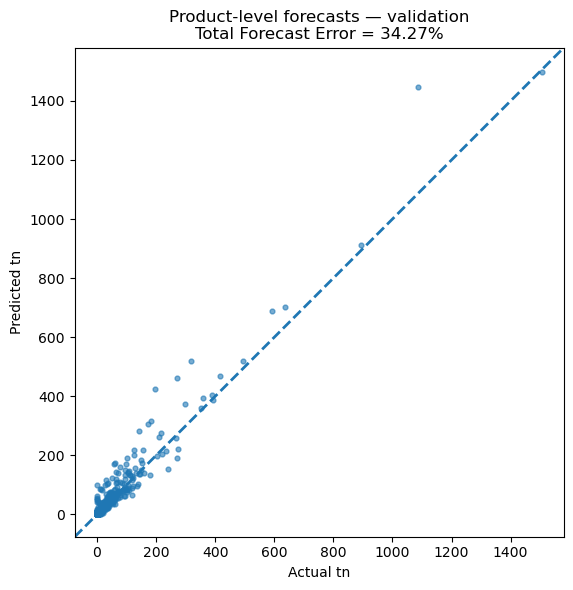

In [26]:
# ── Compute the axis limits ─────────────────────────────────────────────────
both = np.concatenate([y_valid, y_pred_valid])
lo, hi = both.min(), both.max()
pad = 0.05 * (hi - lo)                   # small margin for nicer frame
lo -= pad
hi += pad

# ── Plot ────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 6))
plt.scatter(y_valid, y_pred_valid, alpha=0.6, s=12)
plt.plot([lo, hi], [lo, hi], lw=2, linestyle='--')   # 45° perfect‐fit line
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("Actual tn")
plt.ylabel("Predicted tn")
plt.title(f"Product-level forecasts — validation\nTotal Forecast Error = {tfe_valid:.2%}")
plt.tight_layout()
plt.show()

In [27]:

def plot_product_timeseries(actual_df,
                            product_id,
                            pred_df,
                            *,
                            actual_col="tn",
                            pred_col="pred_tn",
                            date_col="periodo",
                            actual_color="#1f77b4",   # classic Matplotlib blue
                            pred_color="#ff7f0e"      # classic Matplotlib orange
                           ):
    """
    Plot monthly actual vs-predicted sales for a single product.

    Parameters
    ----------
    actual_df : pd.DataFrame
        Must hold columns: product_id, periodo (datetime), tn.
    product_id : int or str
        The product you want to visualise.
    pred_df : pd.DataFrame
        Must hold the same keys plus a prediction column (default 'pred_tn').
    actual_col, pred_col, date_col : str
        Column names for actuals, predictions, and the timestamp.
    actual_color, pred_color : str (HTML/CSS colour codes)
        Override to customise colours.
    """

    # ── slice & sort ──────────────────────────────────────────────────────────
    act = (
        actual_df.loc[actual_df["product_id"] == product_id,
                      [date_col, actual_col]]
        .sort_values(date_col)
        .reset_index(drop=True)
    )

    pred = (
        pred_df.loc[pred_df["product_id"] == product_id,
                    [date_col, pred_col]]
        .sort_values(date_col)
        .reset_index(drop=True)
    )

    # ── plot ─────────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(act[date_col], act[actual_col],
            marker="o", lw=2, color=actual_color, label="Actual")

    if not pred.empty:
        ax.plot(pred[date_col], pred[pred_col],
                marker="x", lw=2, ls="--", color=pred_color, label="Predicted")

    # ── cosmetics ────────────────────────────────────────────────────────────
    ax.set_title(f"Monthly sales — Product {product_id}")
    ax.set_ylabel("tn")
    ax.set_xlabel("Month")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

valid_plot = valid_df[["product_id", "periodo", "tn"]].copy()
valid_plot["pred_tn"] = y_pred_valid

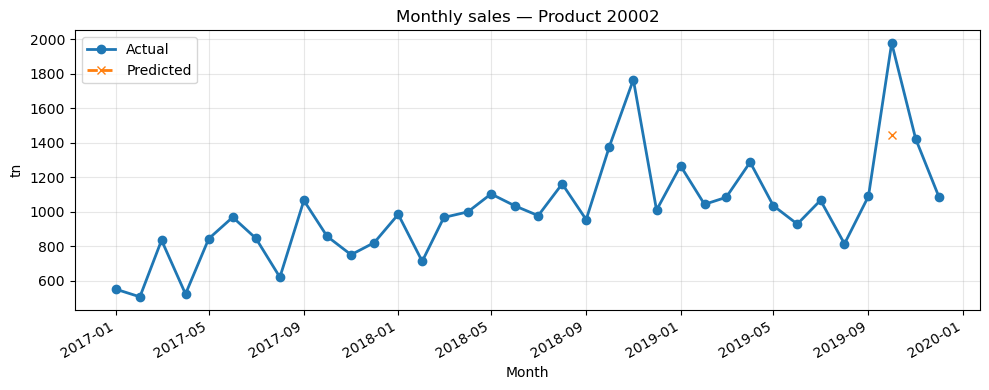

In [28]:
plot_product_timeseries(
    actual_df = monthly_full,   # DataFrame with the ground truth
    product_id = 20002,         # change as you explore
    pred_df = valid_plot           # DataFrame that has 'pred_tn'
)

# Forecast Feb 2020

In [29]:
# Check NaN in test_df
missing_counts_test = X_test.isnull().sum()
print("Missing values in test_df:")
print(missing_counts_test[missing_counts_test > 0])

Missing values in test_df:
avg_delta_pct_12_24    223
dtype: int64


In [ ]:

# Imputar NaN en X_test antes de predecir
# if X_test.isnull().any().any():
#  print("NaN encontrados en X_test, se imputan con 0")
#  X_test = X_test.fillna(0)

NaN encontrados en X_test, se imputan con 0


In [41]:
test_df = test_df.copy()   # keep original cols

# Imputar NaN en X_test antes de predecir
if X_test.isnull().any().any():
    print("NaN encontrados en X_test, se eliminan las filas con NaN")
    X_test = X_test.dropna()

# Prediccion
raw_pred = best_ridge.predict(X_test)

# Cambio negativos por 0
test_df["pred_tn"] = np.maximum(0, raw_pred) 

forecast_feb2020 = (
    test_df[["product_id", "pred_tn"]]
    .rename(columns={"pred_tn": "forecast_tn"})
)
forecast_feb2020.head()

,product_id,forecast_tn
35,20001,1304.582414
71,20002,989.832324
107,20003,756.857492
143,20004,592.070710
179,20005,595.341994


Keep products to predict


In [43]:
# Abrimos el archivo con los productos que queremos predecir
to_predict = pd.read_csv("datasets/a_predecir.txt", dtype={"product_id": str})
product_ids = to_predict['product_id'].astype(str).unique()

In [44]:
df_filtered = forecast_feb2020[
    forecast_feb2020['product_id'].astype(str).isin(product_ids)
].copy()

# Rename forecast_tn to tn
df_filtered.rename(columns={"forecast_tn": "tn"}, inplace=True)

# Now `df_filtered` contains only the products you care about.
print(df_filtered.head())

print(len(df_filtered))

     product_id           tn
35        20001  1304.582414
71        20002   989.832324
107       20003   756.857492
143       20004   592.070710
179       20005   595.341994
780


In [45]:
df_filtered.to_csv("data/regresion_lineal_clase02.csv", index=False)